In [1]:
import PyKDL as kdl
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf
import numpy as np
import copy
from itertools import repeat

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

util_path = os.path.abspath("../utils/")
sys.path.append(util_path)
import transformation as trans
import projections as proj
import robot_visualize as rbvis

np.set_printoptions(suppress=True)


act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from utils import EpisodicDataset
from utils import find_all_hdf5, flatten_list, get_norm_stats
from utils import load_data # data functions

In [5]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from policy import EPACTPolicy, ACTPolicy
from brl_constants import TASK_CONFIGS

ckpt_path = "/mnt/data1/act/train_act_scara_sim-env-block-pick/epact_effind_cam_wrist_wristdown/"

config_path = ckpt_path + "config.pkl"
policy_model_path = ckpt_path + "policy_step_500000_seed_0.ckpt"

stats_path = ckpt_path + "dataset_stats.pkl"

with open(config_path, "rb") as f:
    policy_config = pickle.load(f)['policy_config']
    print(policy_config)

policy = EPACTPolicy(policy_config)
loading_status = policy.deserialize(torch.load(policy_model_path))

with open(stats_path, "rb") as f:
    stats = pickle.load(f)

pre_process_qpos = (
    lambda s_qpos: torch.from_numpy((s_qpos - stats["qpos_mean"]) / stats["qpos_std"])
    .float()
    .cuda()
    .unsqueeze(0)
)
post_process_action = lambda a: a * stats["action_std"] + stats["action_mean"]

print("loading EPACTPolicy policy success")

{'lr': 1e-05, 'num_queries': 100, 'kl_weight': 10, 'ep_weight': 10.0, 'eff_independent': True, 'hidden_dim': 512, 'dim_feedforward': 3200, 'lr_backbone': 1e-05, 'backbone': 'resnet18', 'enc_layers': 4, 'dec_layers': 7, 'nheads': 8, 'camera_names': ['wrist', 'wrist_down'], 'vq': False, 'vq_class': None, 'vq_dim': None, 'action_dim': 5, 'state_dim': 4, 'no_encoder': False}
EPACTPolicy eff independent True
EPACT Args:  Namespace(lr=1e-05, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, backbone='resnet18', dilation=False, position_embedding='sine', camera_names=['wrist', 'wrist_down'], enc_layers=4, dec_layers=7, dim_feedforward=3200, hidden_dim=512, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, eval=False, onscreen_render=False, ckpt_dir='/mnt/data1/act/act_demo_z1_push_red/ckpt', policy_class='EPACT', task_name='act_demo_z1_push_red', seed=0, num_steps=2000, kl_weight=10, chunk_size=None, temporal_agg=False, use_vq

/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


build_epact.eff_independent:  True
EPDETRVAE V6 End Effector Independent
Use end_pose_to_action:  True
Use VQ: False, None, None
number of parameters: 95.21M
EPACTPolicy ep_weight 10.0
KL Weight 10
loading EPACTPolicy policy success


In [8]:
urdf_path =  "/home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf"
print("URDF Path: ", urdf_path)
(ok, tree)  = kdl_parser_py.urdf.treeFromFile(urdf_path)
print("kdl_parse urdf ok?: ", ok)
chain = tree.getChain("world", "camera_link")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)


URDF Path:  /home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf
kdl_parse urdf ok?:  True


In [9]:
camera_names = policy_config["camera_names"]
print(camera_names)

['wrist', 'wrist_down']


In [10]:
def pre_proccess_img(img):
    img_torch = torch.from_numpy(img).unsqueeze(0)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

def pre_process_multi_img(curr_images):
    # a list of images [w, h, 3]
    curr_image = np.stack(curr_images, axis=0)
    img_torch = torch.from_numpy(curr_image)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

def post_process_all_actions(all_actions):
    # post process all actions
    joint_states_traj = []
    actual_actions = []
    for i, raw_action in enumerate(all_actions):
        actual_action = post_process_action(raw_action)
        actual_actions.append(actual_action)
    actual_actions = np.asarray(actual_actions)
    # print(actual_actions)
    return actual_actions

def get_camera_in_world_and_init(ee_poses_raw, init_states=None):
    transformation_matrix, rot_mat_ext, translation_mat= trans.kdl_frame_to_mat(ee_poses_raw[0])
    ee_in_world_init = transformation_matrix
    world_T_init = np.linalg.inv(ee_in_world_init)

    ee_in_world_all = []
    ee_in_init_all = []
    ee_in_init_all_pos = []
    ee_in_world_all_pos = []
    for ee_pose in ee_poses_raw:
        ee_in_world_all_pos.append([ee_pose.p[0], ee_pose.p[1], ee_pose.p[2], 1])
        ee_in_world, _, _= trans.kdl_frame_to_mat(ee_pose)
        ee_in_world_all.append(ee_in_world)
        ee_in_init = world_T_init.dot(ee_in_world)
        ee_in_init_all.append(ee_in_init)
        ee_in_init_all_pos.append(ee_in_init[:3, 3])
        
        # print("ee rpy: ", tf.euler_from_matrix(ee_in_init, 'rxyz'))

    ee_in_init_all_pos = np.asarray(ee_in_init_all_pos)
    ee_in_world_all_pos = np.asarray(ee_in_world_all_pos)
    ee_in_init_all = np.asarray(ee_in_init_all)
    return  ee_in_init_all_pos, ee_in_world_all_pos, ee_in_init_all

def repeater(data_loader):
    epoch = 0
    for loader in repeat(data_loader):
        for data in loader:
            yield data
        print(f'Epoch {epoch} done')
        epoch += 1

In [11]:
(ok, tree)  = kdl_parser_py.urdf.treeFromFile("../hitbot_model.urdf")
print("ok: ", ok)
chain = tree.getChain("world", "camera_link")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)
rgb_p = np.asarray([[429.76348876953125, 0.0, 321.4649658203125, 
                     0.0, 0.0, 429.129150390625, 242.32749938964844, 
                     0.0, 0.0, 0.0, 1.0, 0.0]]).reshape([3, 4])
rgb_p

ok:  True


array([[429.76348877,   0.        , 321.46496582,   0.        ],
       [  0.        , 429.12915039, 242.32749939,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [67]:
dataset_path_list = find_all_hdf5("/mnt/data1/act/train_act_scara_sim-env-block-pick/", skip_mirrored_data=False)
norm_stats, all_episode_len = get_norm_stats(dataset_path_list)

camera_names = ['wrist', 'wrist_down', 'top']
train_episode_ids = [0, 1]
train_episode_len = [all_episode_len[i] for i in train_episode_ids]

val_episode_ids = [0, 1]
val_episode_len = [all_episode_len[i] for i in val_episode_ids]

chunk_size = 64

dataset_dir = "/mnt/data1/act/train_act_scara_sim-env-block-pick/"

TASK_CONFIGS = {
        'epact':{
        'dataset_dir': dataset_dir + '/train_act_scara_3cam',
        'num_episodes': 100,
        'episode_len': 300,
        'camera_names': ['wrist', 'wrist_down', 'top']
    }
}
task_config = TASK_CONFIGS['epact']
name_filter = task_config.get('name_filter', lambda n: True)
batch_size_train = 1
batch_size_val = 1

chunk_size = 100
skip_mirrored_data = False
load_pretrain = False
train_ratio = 0.99
policy_class = "EPACT"
train_dataloader,val_dataloader, stats, _ = load_data(dataset_dir, 
                                                       name_filter, 
                                                       camera_names, 
                                                       batch_size_train, 
                                                       batch_size_val, 
                                                       chunk_size,
                                                       skip_mirrored_data,
                                                       load_pretrain,
                                                       policy_class,
                                                       stats_dir_l=None,
                                                       sample_weights=None,
                                                       train_ratio=train_ratio)
train_dataloader = repeater(train_dataloader)


Found 511 hdf5 files
Found 511 hdf5 files


Data from: ['/mnt/data1/act/train_act_scara_sim-env-block-pick/']
- Train on [505] episodes
- Test on [6] episodes


Found 511 hdf5 files
Norm stats from: ['/mnt/data1/act/train_act_scara_sim-env-block-pick/']
train_episode_len: [286, 224, 311, 161, 171, 151, 197, 229, 199, 306, 560, 420, 244, 226, 237, 305, 166, 188, 222, 246, 297, 291, 235, 196, 363, 234, 208, 258, 132, 212, 177, 211, 164, 163, 149, 485, 294, 398, 274, 178, 373, 212, 243, 204, 164, 254, 223, 245, 287, 206, 226, 155, 207, 220, 203, 258, 287, 266, 249, 197, 284, 307, 233, 212, 194, 276, 180, 192, 166, 309, 225, 297, 196, 245, 244, 220, 176, 178, 287, 292, 170, 244, 161, 170, 178, 379, 265, 188, 194, 234, 159, 296, 277, 372, 171, 249, 202, 213, 446, 217, 259, 237, 194, 215, 155, 179, 242, 291, 425, 236, 221, 180, 160, 226, 203, 173, 204, 174, 238, 176, 275, 203, 222, 204, 177, 159, 208, 156, 220, 258, 317, 236, 207, 255, 234, 214, 224, 178, 227, 215, 236, 199, 221, 167, 165, 2

In [68]:
data = next(train_dataloader)
image_data_cpu, qpos_data_cpu, action_data_cpu, is_pad, end_pose_data = data
image_data, qpos_data, action_data, is_pad, end_pose_data = image_data_cpu.cuda(), qpos_data_cpu.cuda(), action_data_cpu.cuda(), is_pad.cuda(), end_pose_data.cuda()

print("image_data", image_data.shape)
print("qpos_data", qpos_data.shape)
print("action_data", action_data.shape)
print("is_pad", is_pad.shape)
print("end_pose_data", end_pose_data.shape)


qpos:  (4,)
qpos: padded_action: qpos:  (100, 5) 
(4,)qpos:  np.append(qpos, 0): 
(4,) qpos: padded_action:  
 (4,)(5,)padded_action:  
(100, 5)(4,)
 padded_action: 

all_actions: (100, 5) padded_action: np.append(qpos, 0):  
  (101, 5)(100, 5)qpos: (100, 5)np.append(qpos, 0): (5,)


 np.append(qpos, 0): 
(5,)np.append(qpos, 0):   (5,) 
all_actions: 
qpos: (4,)all_actions: all_actions: (5,)  
  (101, 5)(101, 5)
(4,)(101, 5)
padded_action: 


all_actions:   padded_action: (100, 5)(101, 5)qpos: 

 (100, 5)np.append(qpos, 0): 
  np.append(qpos, 0): (5,)(4,) 

(5,)all_actions: padded_action: 
  (101, 5)all_actions: (100, 5)
 
(101, 5)np.append(qpos, 0): 
 (5,)
all_actions:  (101, 5)
qpos:  (4,)
padded_action:  (100, 5)
np.append(qpos, 0):  (5,)
all_actions:  (101, 5)
qpos:  (4,)
padded_action:  (100, 5)
np.append(qpos, 0):  (5,)
all_actions:  (101, 5)
image_data torch.Size([1, 3, 3, 480, 640])
qpos_data torch.Size([1, 4])
action_data torch.Size([1, 100, 5])
is_pad torch.Size([1, 100])
end_

qpos:  (4,)
padded_action:  (100, 5)
np.append(qpos, 0):  (5,)
all_actions:  (101, 5)
qpos:  (4,)
padded_action:  (100, 5)
np.append(qpos, 0):  (5,)qpos: 
 (4,)all_actions: 
 padded_action: (101, 5) 
(100, 5)
np.append(qpos, 0):  (5,)
all_actions:  (101, 5)
qpos:  (4,)
padded_action:  (100, 5)
np.append(qpos, 0):  (5,)
qpos: all_actions:   (4,)(101, 5)

padded_action:  (100, 5)qpos:  
(4,)np.append(qpos, 0): 
 padded_action: (5,) 
(100, 5)all_actions: 
np.append(qpos, 0):   (101, 5)(5,)

all_actions:  (101, 5)
qpos:  (4,)
padded_action:  (100, 5)
np.append(qpos, 0):  (5,)
all_actions:  (101, 5)


(100, 5)
(480, 640, 3)


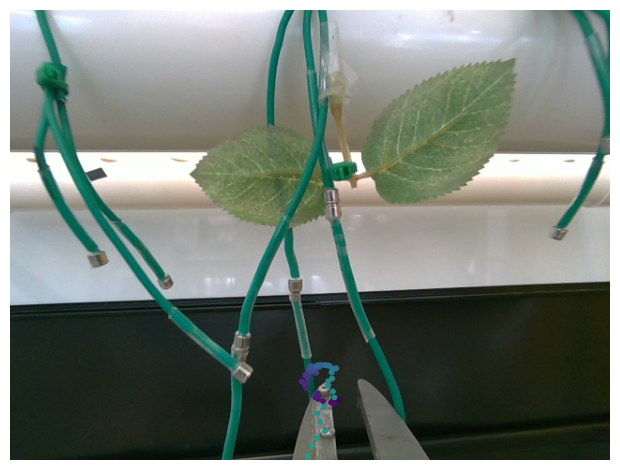

In [23]:
all_actions_gt = action_data_cpu.squeeze().numpy()
image = image_data_cpu.squeeze().numpy()[0].transpose(1, 2, 0)
qpos = qpos_data_cpu.squeeze().numpy()
print(all_actions_gt.shape)
print(image.shape)
actual_actions = post_process_all_actions(all_actions_gt)
all_actions = np.vstack([np.append(qpos, 0), actual_actions])

vis_actions = actual_actions 
rbvis.paint_action_in_image(image, vis_actions, rgb_p, fk_solver, chain, save_path=None)

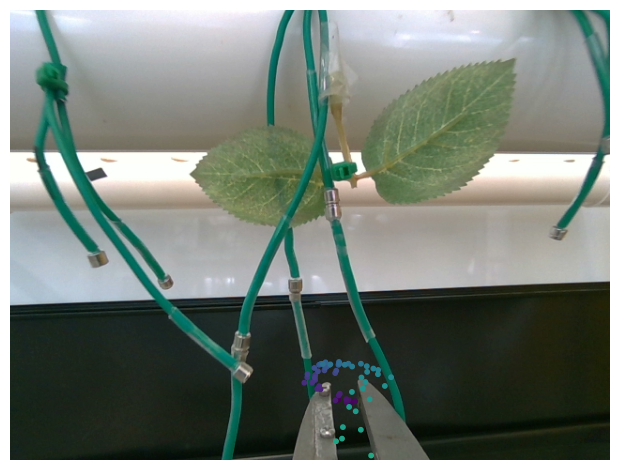

In [24]:
all_actions_hat, end_poses = policy(qpos_data, image_data)
all_actions_hat = all_actions_hat.squeeze(0).cpu().detach().numpy()
actual_actions = post_process_all_actions(all_actions_hat)
all_actions = np.vstack([np.append(qpos, 0), actual_actions])

vis_actions = actual_actions # Predicted action

rbvis.paint_action_in_image(image, vis_actions, rgb_p, fk_solver, chain, save_path=None)

In [34]:
actual_actions_hat = post_process_all_actions(all_actions_hat)
actual_actions_gt = post_process_all_actions(all_actions_gt)


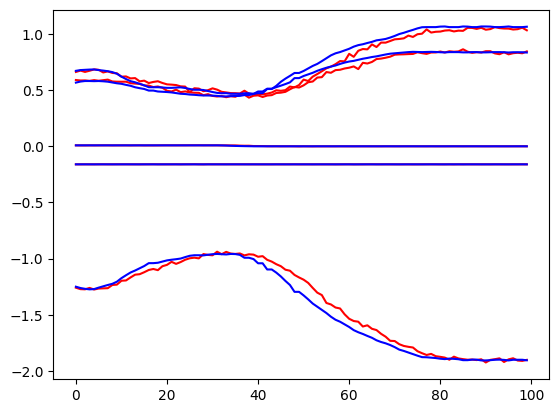

In [37]:
plt.plot(actual_actions_hat, label="predicted", color="red")
plt.plot(actual_actions_gt, label="gt", color="blue")

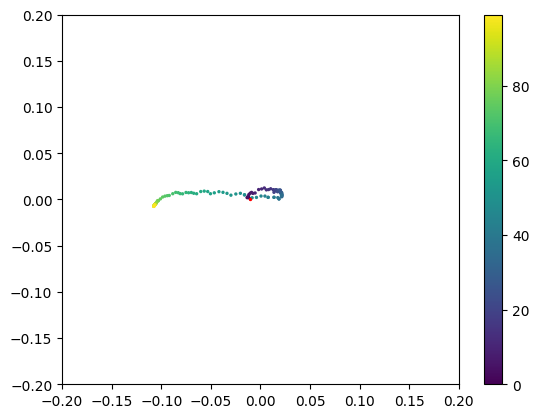

In [25]:
end_pose_gt = end_pose_data.squeeze(0).cpu().detach().numpy()
plt.scatter(end_pose_gt[:, 0], end_pose_gt[:, 1], c=range(len(end_pose_gt)), s=2)

plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.colorbar()
plt.scatter(end_pose_gt[0, 0], end_pose_gt[0, 1], c='r', s=2)


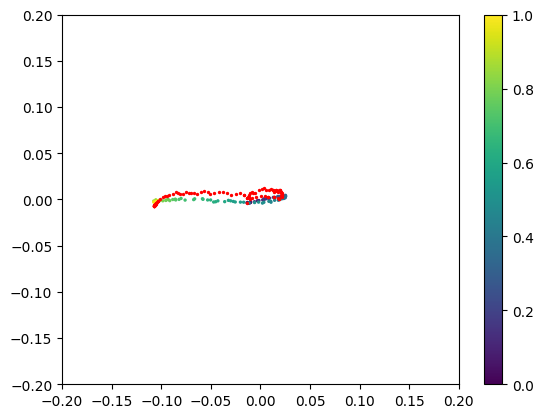

In [50]:
end_poses_hat = end_poses.squeeze(0).cpu().detach().numpy()
plt.scatter(end_poses_hat[:, 0], end_poses_hat[:, 1], c=range(len(end_poses_hat)), s=2)
plt.scatter(end_pose_gt[:, 0], end_pose_gt[:, 1], c='r', s=2)


plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.colorbar()
plt.scatter(end_poses_hat[0, 0], end_poses_hat[0, 1], c='r', s=2)


### Evaluate Inverse Kinematics Module


In [55]:
from  utils import get_camera_in_world_and_init, get_camera_poses, batch_transform_to_xyzyrp_transformations, get_camera_in_world_and_init_samedim

In [56]:
ee_poses, ee_poses_raw, link_poses_list = get_camera_poses(actual_actions_gt, fk_solver, chain)
print("ee_poses_raw: ", len(ee_poses_raw))
ee_pts_init, ee_in_world_all_pos, ee_in_init_all = get_camera_in_world_and_init_samedim(ee_poses_raw)
print("ee_in_init_all: ", ee_in_init_all.shape)
ee_pose = batch_transform_to_xyzyrp_transformations(ee_in_init_all)
# print("ee_pose: ", ee_pose.shape)
# print("ee_pose: ", ee_pose)
end_pose_data = torch.from_numpy(ee_pose).float()

ee_poses_raw:  100
ee_in_init_all:  (100, 4, 4)


In [57]:
actual_actions_gt.shape

(100, 5)

In [58]:
ee_pose.shape

(100, 6)

(-0.2, 0.2)

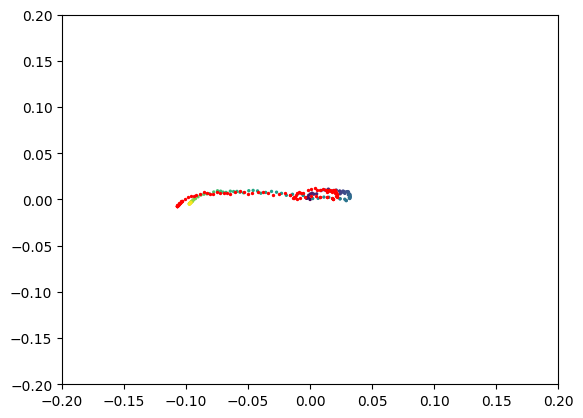

In [59]:
plt.scatter(ee_pose[:, 0], ee_pose[:, 1], c=range(len(ee_pose)), s=2)
plt.scatter(end_pose_gt[:, 0], end_pose_gt[:, 1], s=2, c='r')
# plt.scatter(end_poses_hat[:, 0], end_poses_hat[:, 1], s=2, c='g')

plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])